# We compare the dataset to reference ranges of healthy pregnent women 

### I will use different matrices, and score each test across matrices
1. Agreement with literature of healhty cohort
2. Number of tests
3. Number of test distribution across time
4. Abnormal BMI/age trend

## 1. Agreement with literature of healhty cohort

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import warnings
import matplotlib.cbook
import matplotlib as mpl
import matplotlib.image as mpimg
import time
import itertools
import seaborn as sns
import os
import json
from sympy import *
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.fftpack import rfft,fft,fftfreq,rfftfreq
from scipy.signal import medfilt, find_peaks
from scipy.io import loadmat
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit,brute,basinhopping
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
import math
from itertools import combinations
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from string import ascii_uppercase as abc; abc = abc
try:
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm_notebook as tqdm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from itertools import compress, product
import random
from scipy.interpolate import InterpolatedUnivariateSpline as spline_interp
import warnings
warnings.filterwarnings("ignore")
import matplotlib.patheffects as PathEffects
matplotlib_axes_logger.setLevel('ERROR')
np.seterr(divide='ignore', invalid='ignore')

def_color  = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

init_printing()
plt.rc('font', size=8) 
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.rc('axes', titlesize=8) 
matplotlib.rcParams["figure.dpi"] = 100

# General functions

In [2]:
def remove_top_right_frame(axes):
    for ax in axes:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

def remove_axe_labels(ax):
    ax.set_title('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
        
def to_dict(keys,values):
    return dict(zip(keys,values))

def get_test_dataframe(path,file):
    tdf       = pd.read_csv(path+file)
    tdf.index = np.array([np.array(s.replace('[','').replace(')','').split(',')).astype(int).mean() for s in tdf['week']])
    tdf       = tdf.drop(columns=['week'])
    tdf.rename(columns={"age50": "age"},inplace=True)
    if len(tdf)<140:
        missing_index = np.sort(list(set(np.arange(-59.5,80.5,1)) - set(tdf.index)))
        tdf = tdf.T
        [tdf.insert(int(np.argwhere(np.arange(-59.5,80.5,1) == missing_index[i])[0][0]),missing_index[i],np.nan) for i in range(len(missing_index))]
        tdf = tdf.T
    return tdf

# Loading the dataset
### Metadata infotmation
* 'metadata' - Tests names in various forms, divison to groups and units
* 'labnorm'  - Referenence values for tests

We consider only tests with reference values

In [3]:
# Loading the dataset into 'dfs'
path          = '../Clalit Data/pregnancy.1w/'
files         = [file for file in os.listdir(path)]
all_tests     = [file.split('.')[0] for file in files]
dfs           = dict(zip(all_tests,[get_test_dataframe(path,file) for file in files]))
print(len(all_tests))
# We removed duplicate tests
# Duplicate tests include K:POTASSIUM_BLOOD, Na:SODIUM_BLOOD, RDW:RDW_CV
remove        = ['POTASSIUM_BLOOD','SODIUM_BLOOD','RDW_CV']
all_tests     = np.unique(list(set(all_tests)- set(remove)))
print(len(all_tests))

groups        = ['Liver','Renal','Musculoskeletal','Metabolism','RBCs','Coagulation','Immune','Endocrine']
metadata      = pd.read_excel('../Files/Metadata.xlsx',index_col=0).drop(remove)
labnorm       = pd.read_csv('../Files/LabNorm.csv')

ndf           = pd.DataFrame([dfs[test]['n'] for test in all_tests],index=all_tests).fillna(0).astype(int)
# low_count     = list(ndf.loc[ndf.min(axis=1).sort_values()<20].index)
labnorm_tests = list(metadata.loc[~metadata['LabNorm name'].isna()].index)
removed_tests = set(list(set(all_tests) - set(labnorm_tests)))# + low_count)
tests         = sorted(list(set(labnorm_tests).intersection(all_tests)))# - set(low_count)))
print(len(tests))

112
109
89


In [4]:
def get_age_matched_reference(test):
    age  = int(np.nanmedian(dfs[test]['age']))
    tdf  = labnorm.loc[(labnorm.age==age)&(labnorm.lab==metadata.loc[test]['LabNorm name'])].fillna(method='ffill').fillna(method='bfill').copy()
    tdf['value'].loc[tdf.value<0] = np.min(tdf['value'].loc[tdf.value>0])
    prob = np.diff(tdf['quantile'])/np.sum(np.diff(tdf['quantile']))
    mu_  = (tdf.value.iloc[1:]*prob).sum()
    sd_  = np.sqrt((prob*((tdf.value.iloc[1:] - mu_)**2)).sum())
    q_to_val = interp1d(tdf['quantile'],tdf['value'])
    return {'quantile':q_to_val,'mean':mu_,'sd':sd_}

def get_value_stats(test):
    tdf = dfs[test]
    n   = tdf['n']
    v   = tdf['mean']
    e   = tdf['sd']/np.sqrt(tdf['n'])
    return pd.DataFrame(np.array([n,v,e]).T,index=tdf.index,columns=['n','value','error'])

def get_quantile_stats(test):
    tdf = dfs[test]
    n   = tdf['n']
    v   = tdf['qmean']
    e   = (tdf['qq75'] - tdf['qq25'])/(np.sqrt(tdf['n'])*0.675*2)
    return pd.DataFrame(np.array([n,v,e]).T,index=tdf.index,columns=['n','value','error'])

def get_value_at_quantile_stats(test):
    tdf = get_quantile_stats(test)
    if test in labnorm_tests:
        ref = get_age_matched_reference(test)
        v   = ref['quantile'](tdf['value'])
        e_p = ref['quantile'](tdf['value']+tdf['error'])
        e_m = ref['quantile'](tdf['value']-tdf['error'])
        e   = ((e_p - v) + (v-e_m))/2
        return pd.DataFrame(np.array([tdf['n'],v,e]).T,index=tdf.index,columns=['n','value','error'])
    else:
        return pd.DataFrame(index=tdf.index,columns=['n','value','error'])

def get_SDS_stats(test):
    tdf      = get_value_stats(test)
    if test in labnorm_tests:
        ref      = get_age_matched_reference(test)
        ref_mean = ref['mean'] 
        ref_sd   = ref['sd']
        v        = (tdf['value'] - ref_mean) / ref_sd
        e        = tdf['error'] / ref_sd
        return pd.DataFrame(np.array([tdf['n'],v,e]).T,index=tdf.index,columns=['n','value','error'])
    else:
        return pd.DataFrame(index=tdf.index,columns=['n','value','error'])

def get_test_data(test):
    return {'mean'             :get_value_stats(test),
            'quantile'         :get_quantile_stats(test),
            'value_at_quantile':get_value_at_quantile_stats(test),
            'SDS'              :get_SDS_stats(test)}

def get_stats_from_dataset(test,stat,period=[-60,80],merge_timepoints = True):
    
    df       = data[test][stat].copy()
    df['sd'] = df['error']*np.sqrt(df['n'])
 
    split_k = 1
    if merge_timepoints:
        split_k  = np.min([int(np.ceil(np.nanmean((df['error']/(df['value'].std() * 0.15))**2))),7])
        
        if split_k > 1:
            df     = df.reset_index()
            splits = np.array_split(df, int(len(df)/split_k))
            x      = np.array([tdf['index'].mean()                                   for tdf in splits])
            n      = np.array([tdf['n'].sum()                                        for tdf in splits])
            v      = np.array([np.sum(tdf['value']*tdf['n'])/tdf['n'].sum()          for tdf in splits])
            sd     = np.array([np.sqrt(np.sum(tdf['sd']**2*tdf['n'])/tdf['n'].sum()) for tdf in splits])
            e      = sd/np.sqrt(n)
            df     = pd.DataFrame(np.array([n,v,e]).T,columns=['n','value','error'],index=x)
   
    df = df.loc[period[0]:period[1]]
    x  = df.index
    n  = df.n
    v  = df['value']
    e  = df['error']
    return x,v,e,n      

def plot_test(test,stat,ax,c='k',focus_background=True,remove_background=False,n_title=False,period=[-60,80],xticks_interval=20):
    
    try:
        x,v,e,n = get_stats_from_dataset(test,stat,period=period)
        ax.errorbar(x,v,e,c=c,lw=1,fmt='-o',markersize=1,zorder=-3)   
        # choose different setting based on statistic type
        if stat == 'mean':
            ylabel             = 'Mean Test Value'
            ylm                = list(ax.get_ylim())
            add_ref_background = True

        if stat == 'value_at_quantile':
            ylabel             = 'Value At Mean Quantile'
            ylm                = list(ax.get_ylim())
            add_ref_background = True

        if stat == 'quantile':
            ylabel             = 'Mean Quantile'
            ylm                = [0,1]
            add_ref_background = False
            ax.axhline(0.5,lw=1,zorder=-3,c='gray')

        if remove_background:
            add_ref_background = False
            
        # title    
        title     = metadata.loc[test]['Nice name']
        if n_title:
            title = title +', ' + 'n = ' + fmt_num(np.sum(n))    

        # plot the background
        if add_ref_background:
            if test in np.unique(labnorm_tests):
                
                ref = get_age_matched_reference(test)
                ax.axhspan(ref['quantile'](0.03),ref['quantile'](0.97),zorder=-4,alpha=0.1,color='#86bf91')
                ax.axhspan(ref['quantile'](0.10),ref['quantile'](0.90),zorder=-4,alpha=0.1,color='#86bf91')
                ax.axhspan(ref['quantile'](0.15),ref['quantile'](0.85),zorder=-4,alpha=0.2,color='#86bf91')
                ax.axhspan(ref['quantile'](0.25),ref['quantile'](0.75),zorder=-4,alpha=0.3,color='#86bf91')
                ax.axhspan(ref['quantile'](0.35),ref['quantile'](0.65),zorder=-4,alpha=0.5,color='#86bf91')
                md = ref['quantile'](0.5)
                
                if focus_background:
                    ylm = list(ax.get_ylim())
                    if np.min(v) < ylm[0]:
                        ylm[0] = np.min(v)*0.99
                  
                else:
                    if ylm[0] > md:
                        ylm[0] = md*0.99
                    if ylm[1] < md:
                        ylm[1] = md*1.01     
                    ylm = [ylm[0]- (ylm[1] - ylm[0])*0.1,ylm[1]+ (ylm[1] - ylm[0])*0.1]
            else:
                ax.set_facecolor('white')    

        # edit axis labels
        ax.set_xticks(np.arange(period[0],period[1],xticks_interval))
        ax.set_xlim(period)
        ax.set_xlabel('Weeks postpartum')
        ax.set_ylabel(ylabel)
        ax.set_ylim([ylm[0],ylm[1]])
    except:
        ax.set_facecolor('white')    
        title     = metadata.loc[test]['Nice name']
        
    ax.set_title(title)    
    remove_top_right_frame([ax])

In [5]:
data = {test:get_test_data(test) for test in tqdm(all_tests)}

  0%|          | 0/109 [00:00<?, ?it/s]

In [6]:
summery_df  = pd.DataFrame(index=tests)

### Reference ranges during normal pregnancy 

In [7]:
'''
Reference values for clinical chemistry tests during normal pregnancy
A Larsson 1, M Palm, L-O Hansson, O Axelsson
PMID: 18485166 DOI: 10.1111/j.1471-0528.2008.01709.x
'''

tdf       = pd.read_excel('../Files/ref_clinical_ranges.xlsx',index_col=0)
ref_tests = list(set(tdf.index).intersection(tests))
ref_values= {np.split(tdf,len(tdf)/9)[i].index[0]:np.split(tdf,len(tdf)/9)[i].iloc[1:] for i in  range(int(len(tdf)/9))}
ref_ref   = pd.read_excel('../Files/ref_clinical_ranges.xlsx',index_col=0,sheet_name=1)

idx       = np.array([11.1,20.6,25.7,29.1,32.3,36,39.6,50.3,-15]) - 40
idx_ticks = ['7-17','17-24','24-28','28-31','31-34','34-38', 'Predelivery','Postpartum','Nonpregnant'] 

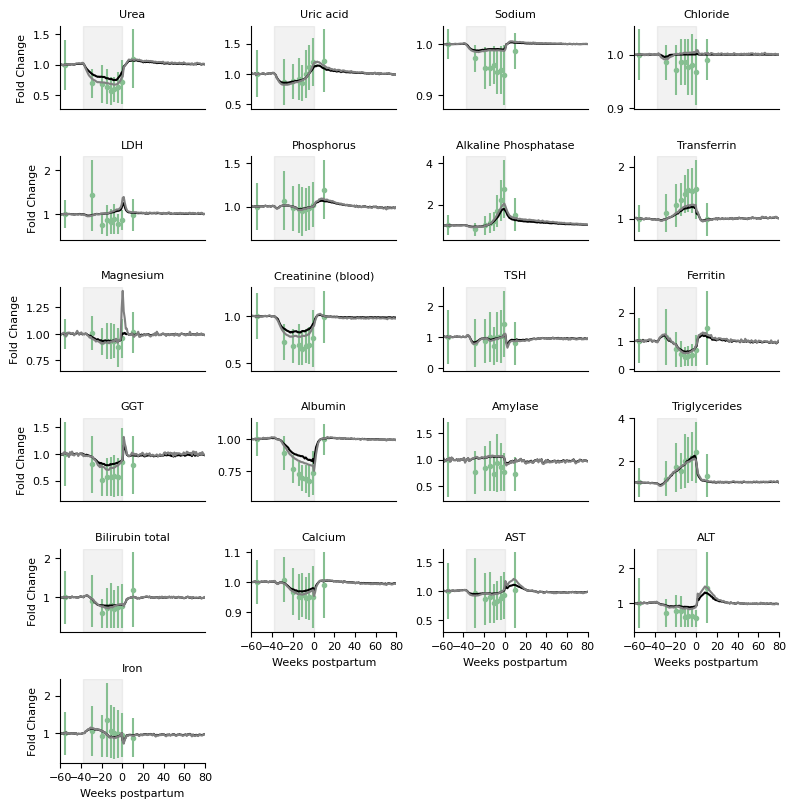

In [8]:
plt.figure(figsize=(8,30))
for i,test in enumerate(ref_tests):
    ax  = plt.subplot(int(np.ceil(len(tests)/4)),4,i+1)
     # reference values fold change
    df        = ref_values[test].copy()
    df.loc['Nonpregnant'] = [s.replace('<','').replace('*','') for s in ref_ref.loc[test].values[0].split('–')]
    low       = np.array([float(df['Lower limit'].values[j].split(' ')[0].replace('<','').replace('*','')) for j in range(len(idx))])
    up        = np.array([float(df['Upper limit'].values[j].split(' ')[0].replace('<','').replace('*','')) for j in range(len(idx))])
    center    = (up+low)/2
    low       = low/center[-1]
    up        = up/center[-1]
    center    = center/center[-1]
    ax.errorbar(idx,center,(center-low,up-center),color='#86bf91',fmt='o',markersize=3,zorder=-4)
    
    # value at quantile fold change
    tdf   = get_test_data(test)['value_at_quantile']
    ax.plot(tdf['value']/np.mean(tdf['value'].loc[:-50]),c='k')
    
    # Mean
    tdf   = get_test_data(test)['mean']
    ax.plot(tdf['value']/np.mean(tdf['value'].loc[:-50]),c='gray')    
    
    remove_top_right_frame([ax])
    ax.set_xticks(np.arange(-60,100,20)) ; ax.set_xlabel('Weeks postpartum'); ax.set_xlim([-60,80])
    ax.axvspan(-38,0,color='gray',alpha=0.1,zorder=-20)
    ax.set_title(metadata.loc[test]['Nice name'])
    ax.set_ylabel('Fold Change')
        
    if i<len(ref_tests)-4:
        ax.set_xticks([])
        ax.set_xlabel('')
    if np.mod(i,4) != 0:
        ax.set_ylabel('')
    
plt.tight_layout(); plt.show()

In [9]:
def line_reg(xdat, ydat,ax,c='k'):
    popt,cov         = np.polyfit(xdat, ydat, 1,cov=True);
    coef_,intercept_ = popt
    ypred            = coef_*xdat + intercept_
    ax.scatter(xdat, ydat, color=c,s=4)
    ax.plot(xdat, ypred, color=c,lw=1,alpha=0.5)

    n     = len(ydat)
    m     = len(popt)
    dof   = n - m
    alpha = 0.05
    tails = 2
    t_critical = stats.t.ppf(1 - (alpha / tails), dof)
    y_bar    = np.mean(ypred)

    resid    = ydat - ypred
    chi2     = sum((resid / ypred)**2)
    chi2_red = chi2 / dof
    std_err  = np.sqrt(sum(resid**2) / dof)

    xlim     = ax.get_xlim()
    x_fitted = np.linspace(np.min(xdat), np.max(xdat), 10)
    y_fitted = coef_*x_fitted + intercept_
    ci       = t_critical * std_err * np.sqrt(1 / n + (x_fitted - np.mean(xdat))**2 / np.sum((xdat - np.mean(xdat))**2))
    ax.fill_between(x_fitted, y_fitted + ci, y_fitted - ci, facecolor=c,alpha=0.2, zorder=0)   

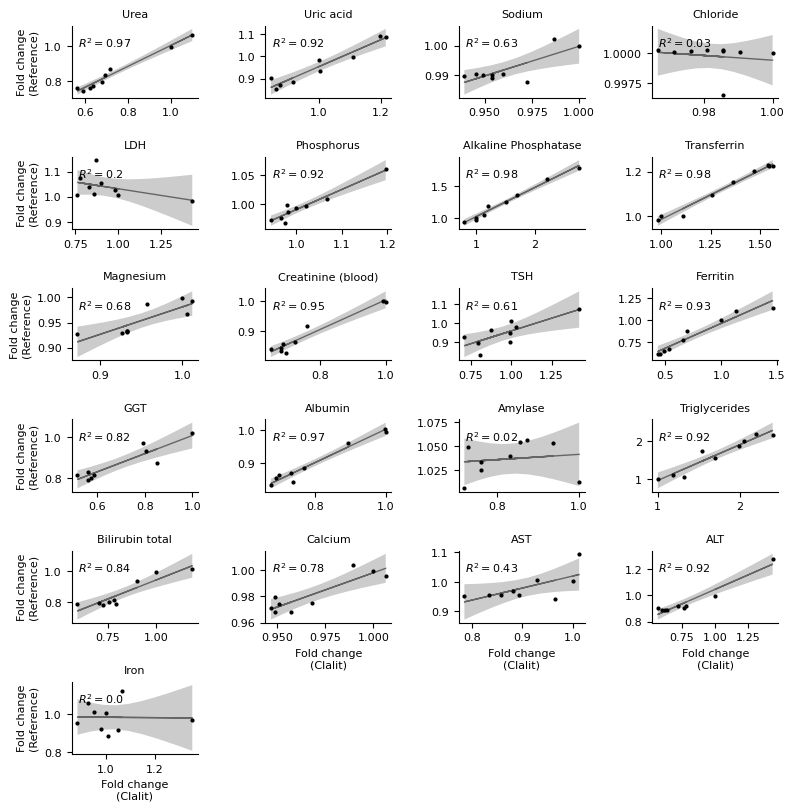

In [10]:
summery = []
plt.figure(figsize=(8,30))
for i,test in enumerate(ref_tests):
    ax  = plt.subplot(int(np.ceil(len(tests)/4)),4,i+1)

    # reference values fold change
    df        = ref_values[test].copy()
    df.loc['Nonpregnant'] = [s.replace('<','').replace('*','') for s in ref_ref.loc[test].values[0].split('–')]
    low       = np.array([float(df['Lower limit'].values[j].split(' ')[0].replace('<','').replace('*','')) for j in range(len(idx))])
    up        = np.array([float(df['Upper limit'].values[j].split(' ')[0].replace('<','').replace('*','')) for j in range(len(idx))])
    center    = (up+low)/2
    low       = low/center[-1]
    up        = up/center[-1]
    center_fc = center/center[-1]
    
    # value at quantile fold change
    tdf       = get_test_data(test)['value_at_quantile']
    qvals_fc  = tdf['value']/np.mean(tdf['value'].loc[:-40])
    qvals_fc  = np.array([qvals_fc.iloc[np.argmin(np.abs(qvals_fc.index - i))] for i in idx])
   
    line_reg(center_fc,qvals_fc,ax,c='k')
    
    r,pval =  stats.pearsonr(center_fc,qvals_fc)
    
    ax.annotate('$R^{2} = $' + str(np.round(r**2,decimals=2)),(0.05,0.7),xycoords='axes fraction',c='k')

    remove_top_right_frame([ax])
    ax.set_title(metadata.loc[test]['Nice name'])
    ax.set_xlabel('Fold change\n(Clalit)')
    ax.set_ylabel('Fold change\n(Reference)')

    if i<len(ref_tests)-4:
        ax.set_xlabel('')
    if np.mod(i,4) != 0:
        ax.set_ylabel('')
    
    summery.append([r,pval])
plt.tight_layout();
plt.savefig('linear_regression_compare_data_to_reference.pdf',bbox_inches = 'tight',pad_inches=0.1);     
plt.show()

In [11]:
summery = pd.DataFrame(summery,columns=['R2','pvalue'],index=ref_tests)
print(len(summery.loc[(summery['R2'] > 0.5) & (summery['pvalue'] <0.05)]),len(summery))

16 21


In [12]:
summery_df['agree with ref'] = 0.5
summery_df['agree with ref'].loc[ref_tests] = ((summery['R2'] > 0.5) & (summery['pvalue'] <0.05))*1

# 2. Number of tests


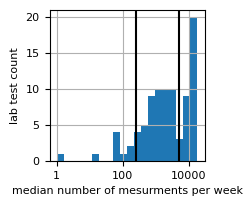

In [13]:
plt.figure(figsize=(2,2))

ax = plt.subplot(111)
tdf = pd.DataFrame([np.nanmedian(dfs[test].loc[-38:0]['n']) for test in tests],index=tests)
np.log10(tdf).hist(bins=20,ax=ax)
ax.set_xticklabels([str(int(10**tick)) for tick in ax.get_xticks()])
ax.axvline(np.log10(250),c='k')
ax.axvline(np.log10(5000),c='k')
ax.set_title('')
ax.set_ylabel('lab test count')
ax.set_xlabel('median number of mesurments per week'); 
plt.savefig('number_of_tests.pdf',bbox_inches = 'tight',pad_inches=0.1);     

plt.show()

In [14]:
summery_df['number of tests'] = np.nan
summery_df['number of tests'].loc[list(tdf.loc[tdf[0]<5000].index)] = 0.5
summery_df['number of tests'].loc[list(tdf.loc[tdf[0]<250].index)]  = 0
summery_df['number of tests'].loc[list(tdf.loc[tdf[0]>5000].index)] = 1

# 3. Number of test distribution across time
The most common blood tests share the same measurment trend across time

They are distributed around the main pregnancy periods
* During pregnancy the number of these tests shows 3 peaks, representing the onset of each trimester.
* In addition, we observe an increase in the number of tests before delivery
* Test numbers peak at term due to hospitalization
* Another peak around 5 weeks postartum, with a decay of ~20 weeks

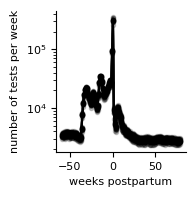

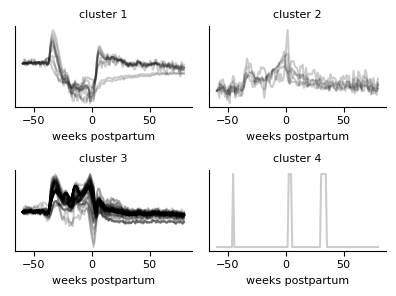

In [15]:
plt.figure(figsize=(2,2))
ax      = plt.subplot(111)
cbc     = np.array(tests)[np.array([np.nanmedian(dfs[test]['n']) for test in tests]) > 3000]
tdf     = pd.DataFrame([dfs[test]['n'] for test in cbc],index=cbc).T
tdf.plot(ax=ax,c='k',alpha=0.2,marker='o',markersize=3,legend=False)
ax.set_xlabel('weeks postpartum')
ax.set_ylabel('number of tests per week')
ax.set_yscale('log')
remove_top_right_frame([ax])
plt.tight_layout()
plt.savefig('CBC_n_distribution.pdf',bbox_inches = 'tight',pad_inches=0.1);     
plt.show()

import scipy.cluster.hierarchy as spc
all_ns  = pd.DataFrame([dfs[test]['n'] for test in tests],index=tests).T.drop(index=[-0.5,0.5])
all_ns  = np.log(all_ns)
all_ns  = all_ns.fillna(method='pad')
all_ns  = (all_ns - all_ns.iloc[0]) / all_ns.std()
pdist   = spc.distance.pdist(all_ns.T)
linkage = spc.linkage(pdist, method='complete')
idx     = spc.fcluster(linkage, 0.45 * pdist.max(), 'distance')

all_ns  = pd.DataFrame([dfs[test]['n'] for test in tests],index=tests).T.drop(index=[-0.5,0.5])
all_ns  = np.log(all_ns)
all_ns  = all_ns.fillna(method='pad')
all_ns  = (all_ns - all_ns.iloc[0]) / all_ns.std()
plt.figure(figsize=(4,3))
axes = [plt.subplot(2,int(np.ceil(len(np.unique(idx))/2)),i+1) for i in range(len(np.unique(idx)))]
[(all_ns[all_ns.columns[idx==i+1]]).plot(ax = axes[i],legend=False,c='k',alpha=0.2)  for i in range(len(np.unique(idx)))]
[ax.set_xlabel('weeks postpartum') for ax in axes]
[ax.set_yticks([]) for ax in axes]
[axes[i].set_title('cluster ' + str(i+1)) for i in range(len(axes))]

remove_top_right_frame(axes)
plt.tight_layout();
plt.savefig('Clusters_n_distribution.pdf',bbox_inches = 'tight',pad_inches=0.1);     
plt.show()

In [16]:
summery_df['tests distribution'] = 0
summery_df['tests distribution'].loc[np.array(tests)[idx==3]] = 1

# 4. Abnormal BMI/age trend

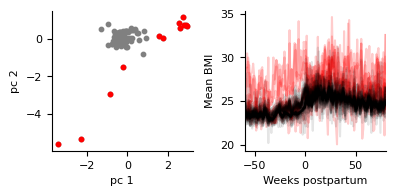

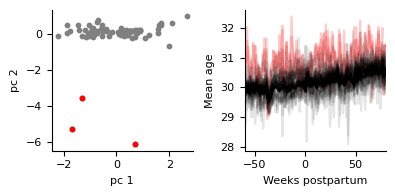

In [17]:
all_bmis        = pd.DataFrame([dfs[test][['bmi']].T.values.flat[:] for test in tests],index=tests,columns=dfs[test][['bmi']].index).dropna().T
pca             = PCA(n_components=2).fit(all_bmis.to_numpy())
pc_scores       = pd.DataFrame(pca.components_,columns=all_bmis.columns).T
pc_scores       = (pc_scores -pc_scores.mean()) / pc_scores.std()
pc_scores['d']  = np.sqrt((pc_scores[0] - np.median(pc_scores[0]))**2 + (pc_scores[1] - np.median(pc_scores[1]))**2)

q1       = np.percentile(pc_scores['d'],25)
q3       = np.percentile(pc_scores['d'],75)
outliers = list(pc_scores.loc[pc_scores['d'] > q3 + 1.5*(q3-q1)].index)

plt.figure(figsize=(4,2))
ax1,ax2 = plt.subplot(121),plt.subplot(122)
ax1.scatter(pc_scores[0],pc_scores[1],c='gray',s=10)
ax1.scatter(pc_scores.loc[outliers][0],pc_scores.loc[outliers][1],c='r',s=10)
ax1.set_xlabel('pc 1'); ax1.set_ylabel('pc 2');
ax2.plot(all_bmis.drop(columns=outliers),c='k',alpha=0.1)
ax2.plot(all_bmis[outliers],c='r',zorder=-4,alpha=0.2)
ax2.set_xlabel('Weeks postpartum'); ax2.set_xlim([-60,80])
ax2.set_ylabel('Mean BMI')
remove_top_right_frame([ax1,ax2])
plt.tight_layout()
plt.savefig('PCA_BMI.pdf',bbox_inches = 'tight',pad_inches=0.1);     
plt.show()

summery_df['abnormal bmi'] = 1
summery_df['abnormal bmi'].loc[outliers] = 0

all_bmis        = pd.DataFrame([dfs[test][['age']].T.values.flat[:] for test in tests],index=tests,columns=dfs[test][['age']].index).dropna().T
pca             = PCA(n_components=2).fit(all_bmis.to_numpy())
pc_scores       = pd.DataFrame(pca.components_,columns=all_bmis.columns).T
pc_scores       = (pc_scores -pc_scores.mean()) / pc_scores.std()
pc_scores['d']  = np.sqrt((pc_scores[0] - np.median(pc_scores[0]))**2 + (pc_scores[1] - np.median(pc_scores[1]))**2)

q1       = np.percentile(pc_scores['d'],25)
q3       = np.percentile(pc_scores['d'],75)
outliers = list(pc_scores.loc[pc_scores['d'] > q3 + 1.5*(q3-q1)].index)

plt.figure(figsize=(4,2))
ax1,ax2 = plt.subplot(121),plt.subplot(122)
ax1.scatter(pc_scores[0],pc_scores[1],c='gray',s=10)
ax1.scatter(pc_scores.loc[outliers][0],pc_scores.loc[outliers][1],c='r',s=10)
ax1.set_xlabel('pc 1'); ax1.set_ylabel('pc 2');
ax2.plot(all_bmis.drop(columns=outliers),c='k',alpha=0.1)
ax2.plot(all_bmis[outliers],c='r',zorder=-4,alpha=0.2)
ax2.set_xlabel('Weeks postpartum'); ax2.set_xlim([-60,80])
ax2.set_ylabel('Mean age')
remove_top_right_frame([ax1,ax2])
plt.tight_layout()
plt.savefig('PCA_AGE.pdf',bbox_inches = 'tight',pad_inches=0.1);     
plt.show()

summery_df['abnormal age'] = 1
summery_df['abnormal age'].loc[outliers] = 0

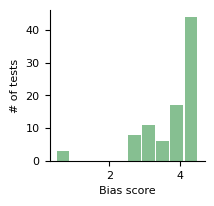

In [18]:
plt.figure(figsize=(2,2))
ax = plt.subplot(111)
summery_df.sum(axis=1).hist(ax=ax,color='#86bf91', zorder=2, rwidth=0.9)
ax.set_ylabel('# of tests')
ax.set_xlabel('Bias score')
ax.grid(False)
remove_top_right_frame([ax])
plt.savefig('scores.pdf',bbox_inches = 'tight',pad_inches=0.1);     

plt.show()

In [19]:
summery_df.to_csv('../Files/bias_score_070523.csv')